示範如何使用SHAP值來理解XGBoost模型預測

In [ ]:
! pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import xgboost as xgboost

from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score ,roc_curve ,classification_report, confusion_matrix ,r2_score ,mean_squared_error, mean_absolute_error ,explained_variance_score

import shap
# print the JS visualization code to the notebook
shap.initjs()

# Load dataset

In [ ]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [ ]:
X # 32561 rows × 12 columns

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


In [ ]:
y

array([False, False, False, ..., False, False,  True])

# Train the model

In [ ]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.54666
[100]	test-logloss:0.36390
[200]	test-logloss:0.31754
[300]	test-logloss:0.30058
[400]	test-logloss:0.29155
[500]	test-logloss:0.28652
[600]	test-logloss:0.28343
[700]	test-logloss:0.28173
[800]	test-logloss:0.28058
[900]	test-logloss:0.27976
[1000]	test-logloss:0.27924
[1100]	test-logloss:0.27893
[1200]	test-logloss:0.27878
[1207]	test-logloss:0.27875


# Classic feature attributions

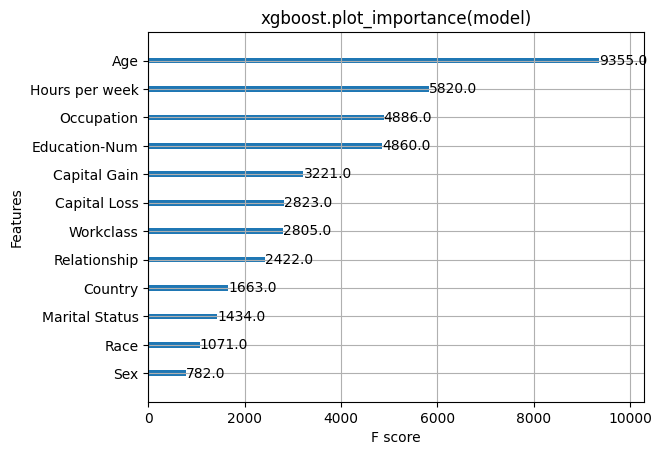

In [ ]:
xgboost.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

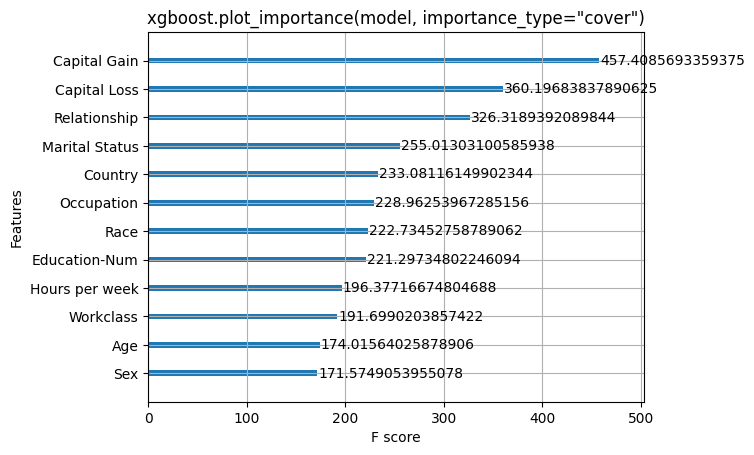

In [ ]:
xgboost.plot_importance(model, importance_type="cover") # importance_type="cover" is the number of times a feature appears in a tree
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

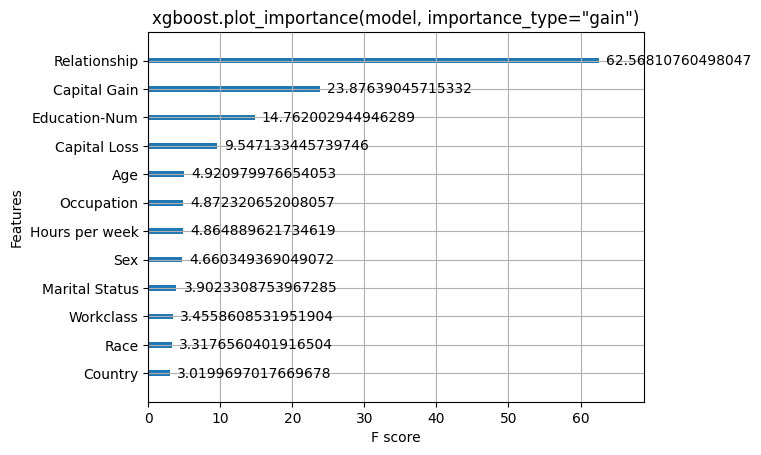

In [ ]:
xgboost.plot_importance(model, importance_type="gain") # importance_type="gain" is the average gain of splits which use the feature
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

# Explain predictions

Tree SHAP 來解釋整個資料集（32561 個樣本）。

In [ ]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Visualize a single prediction

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])

# Visualize many predictions

In [ ]:
shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :]
)

# Bar chart of mean importance

取整個資料集中 SHAP 值大小的平均值，並將其繪製為簡單的長條圖。

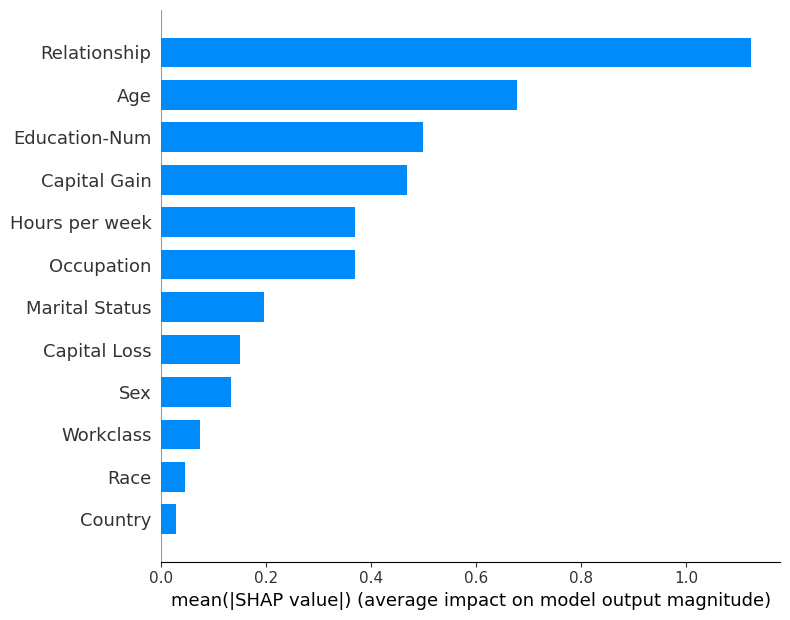

In [ ]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

# SHAP Summary Plot

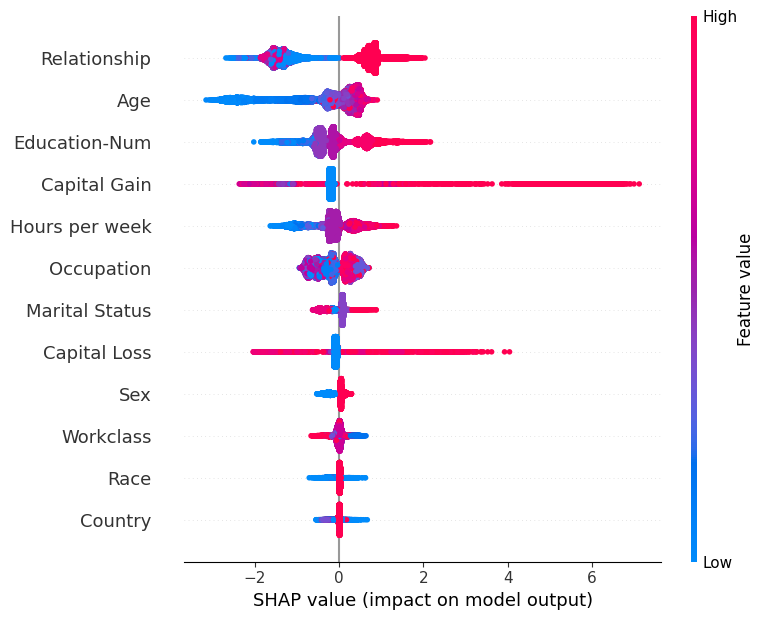

In [ ]:
shap.summary_plot(shap_values, X)

relationship比captial gain有更大的總體模型影響，但對於那些captial gain重要的樣本，它比年齡有更大的影響。換句話說，captial gain對少數預測的影響較大，而age對所有預測的影響較小。

# SHAP Dependence Plots

SHAP dependence plots 顯示單一特徵對整個資料集的影響。

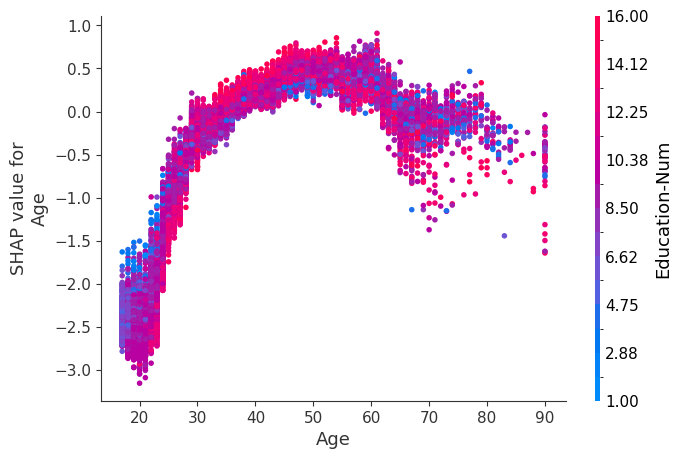

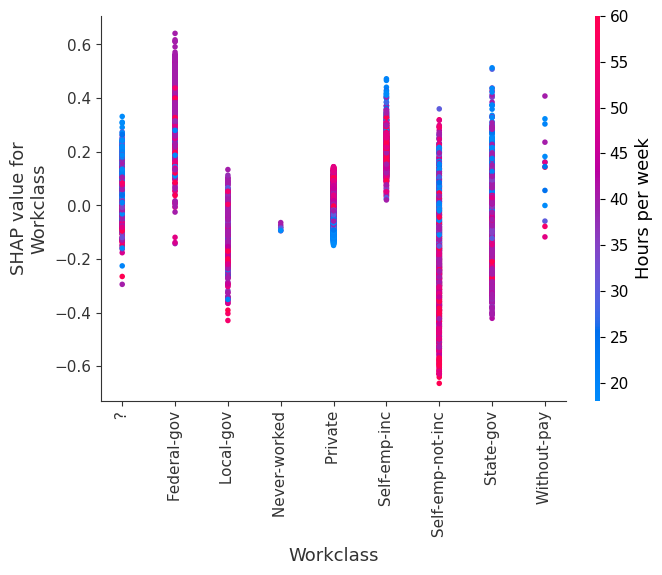

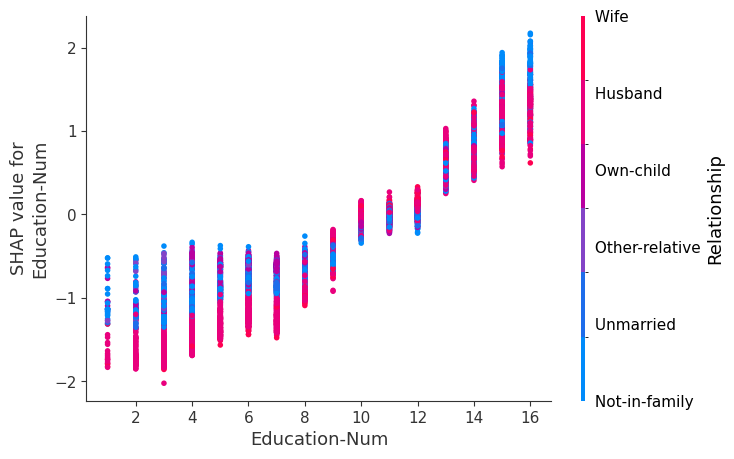

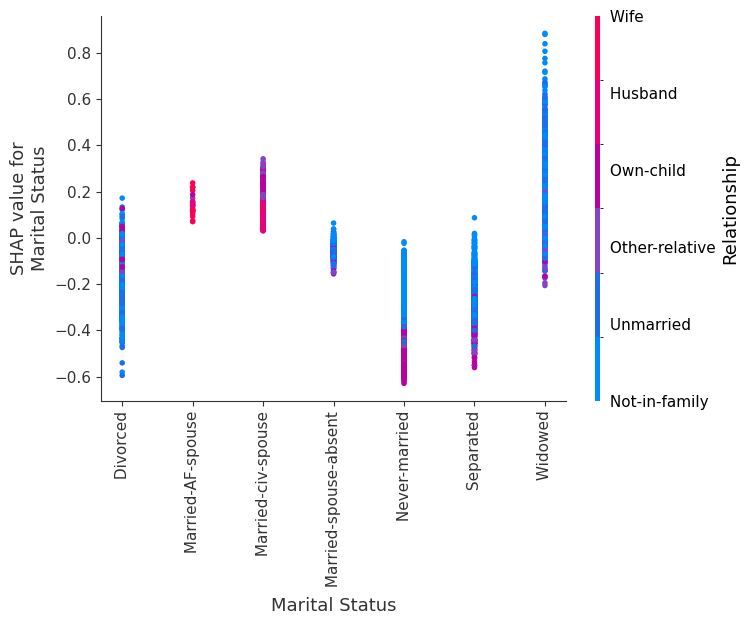

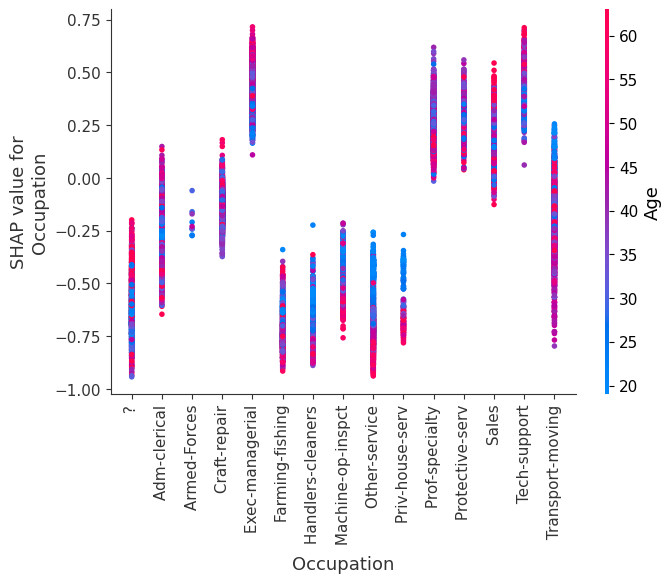

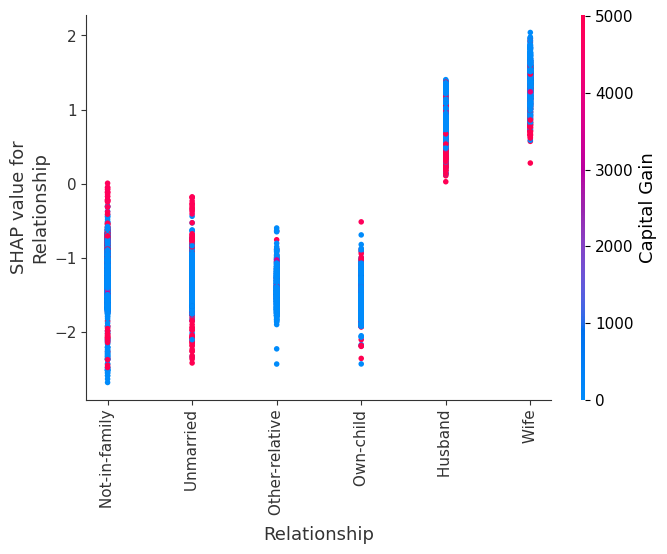

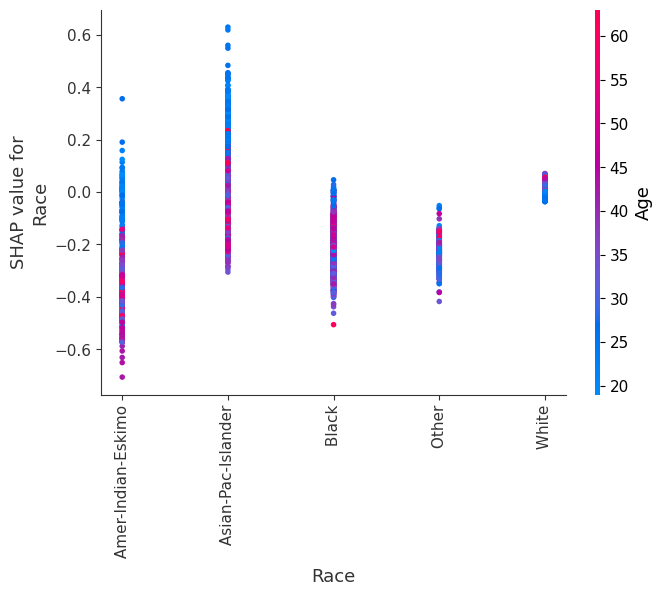

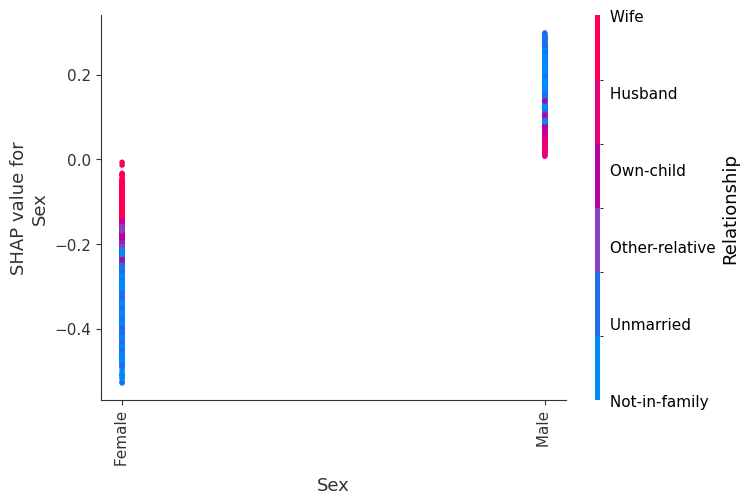

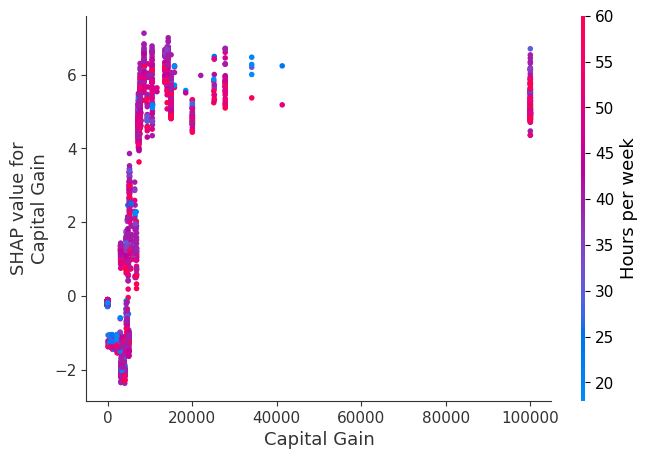

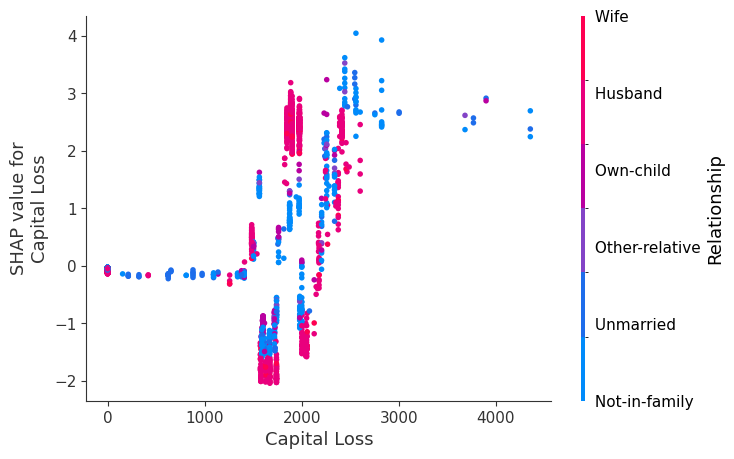

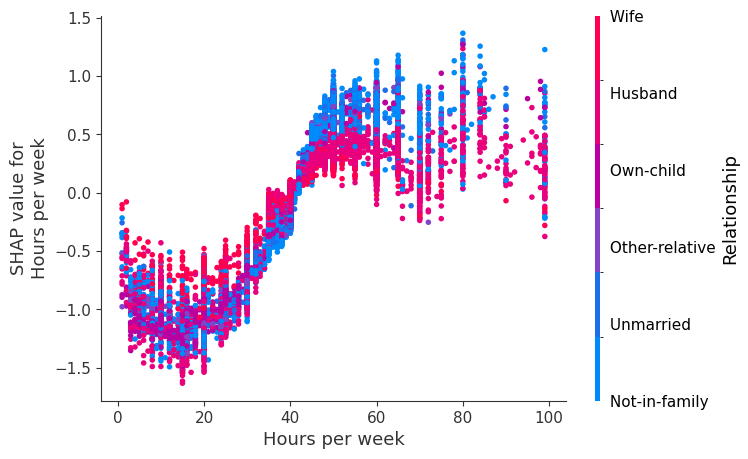

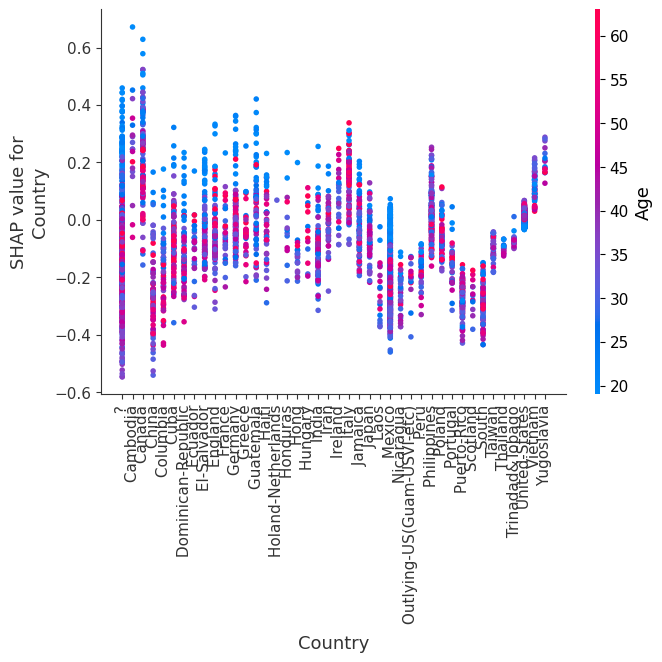

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

# Simple supervised clustering


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000, :]) # 線性降維
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000, :]) # 非線性降維

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cdict1 = {
    "red": (
        (0.0, 0.11764705882352941, 0.11764705882352941),
        (1.0, 0.9607843137254902, 0.9607843137254902),
    ),
    "green": (
        (0.0, 0.5333333333333333, 0.5333333333333333),
        (1.0, 0.15294117647058825, 0.15294117647058825),
    ),
    "blue": (
        (0.0, 0.8980392156862745, 0.8980392156862745),
        (1.0, 0.3411764705882353, 0.3411764705882353),
    ),
    "alpha": ((0.0, 1, 1), (0.5, 1, 1), (1.0, 1, 1)),
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap("RedBlue", cdict1)

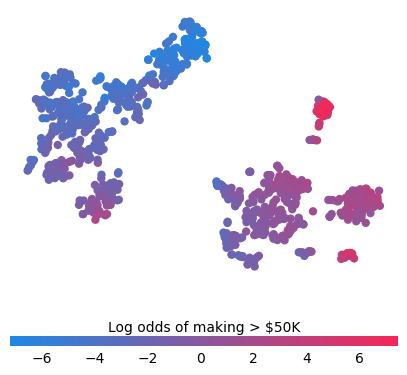

In [ ]:
f = plt.figure(figsize=(5, 5))
plt.scatter(
    shap_embedded[:, 0],
    shap_embedded[:, 1],
    c=shap_values[:1000, :].sum(1).astype(np.float64),
    linewidth=0,
    alpha=1.0,
    cmap=red_blue_solid,
)
cb = plt.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.outline.set_linewidth(0)
cb.ax.tick_params("x", length=0)
cb.ax.xaxis.set_label_position("top")
plt.gca().axis("off")
plt.show()

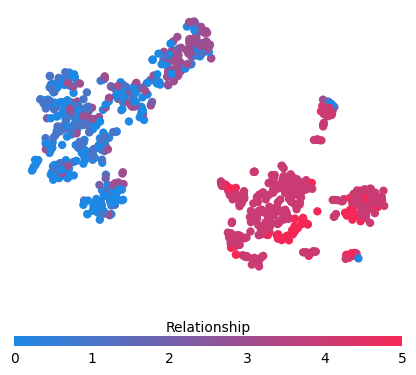

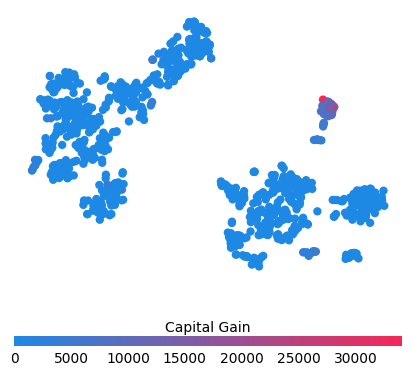

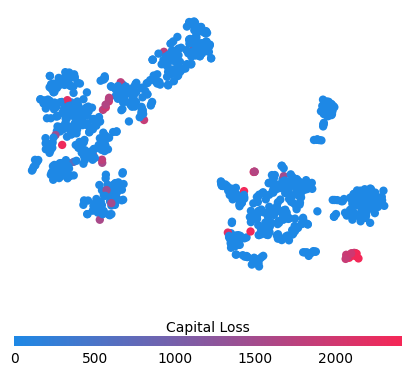

In [ ]:
for feature in ["Relationship", "Capital Gain", "Capital Loss"]:
    f = plt.figure(figsize=(5, 5))
    plt.scatter(
        shap_embedded[:, 0],
        shap_embedded[:, 1],
        c=X[feature].values[:1000].astype(np.float64),
        linewidth=0,
        alpha=1.0,
        cmap=red_blue_solid,
    )
    cb = plt.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.outline.set_linewidth(0)
    cb.ax.tick_params("x", length=0)
    cb.ax.xaxis.set_label_position("top")
    plt.gca().axis("off")
    plt.show()

# Train a model with only two leaves per tree and hence no interaction terms between features

In [ ]:
# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model_ind = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.54123
[100]	test-logloss:0.35516
[200]	test-logloss:0.32865
[300]	test-logloss:0.31912
[400]	test-logloss:0.31369
[500]	test-logloss:0.30943
[600]	test-logloss:0.30654
[700]	test-logloss:0.30408
[800]	test-logloss:0.30212
[900]	test-logloss:0.30042
[1000]	test-logloss:0.29942
[1100]	test-logloss:0.29812
[1200]	test-logloss:0.29702
[1300]	test-logloss:0.29622
[1400]	test-logloss:0.29550
[1500]	test-logloss:0.29507
[1564]	test-logloss:0.29462


In [ ]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


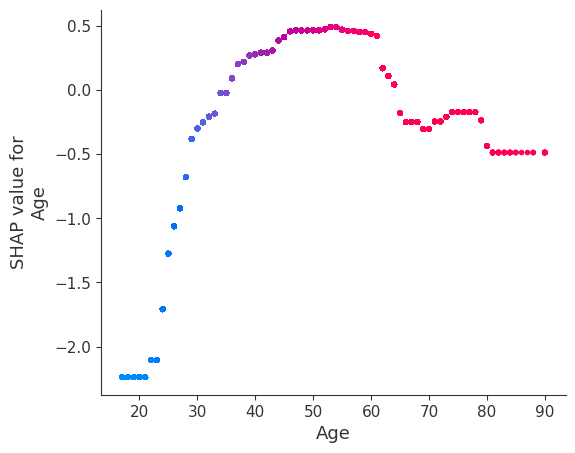

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


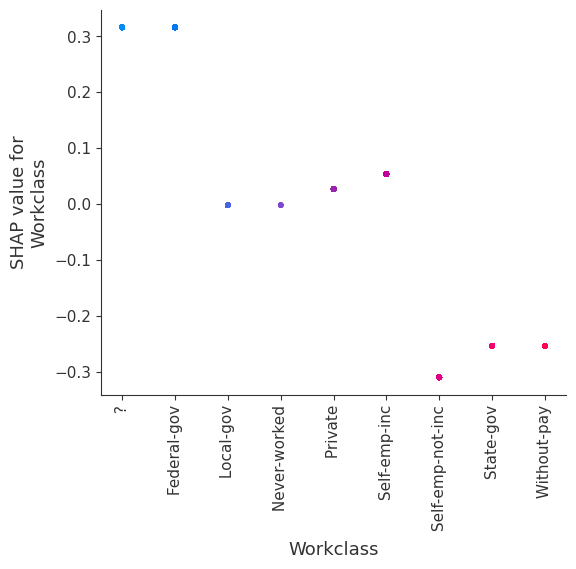

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


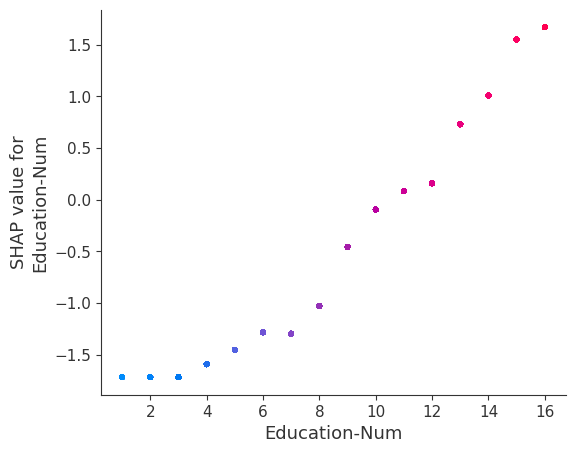

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


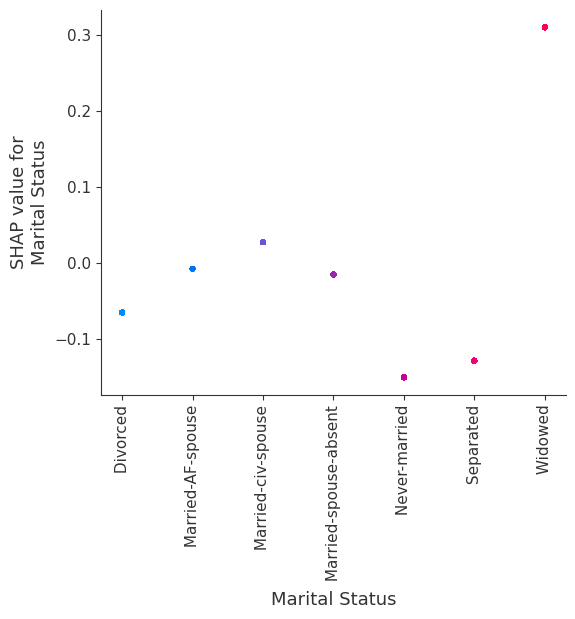

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


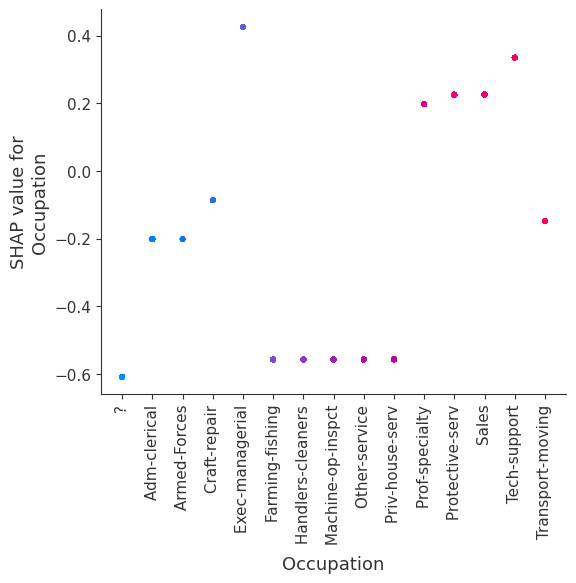

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


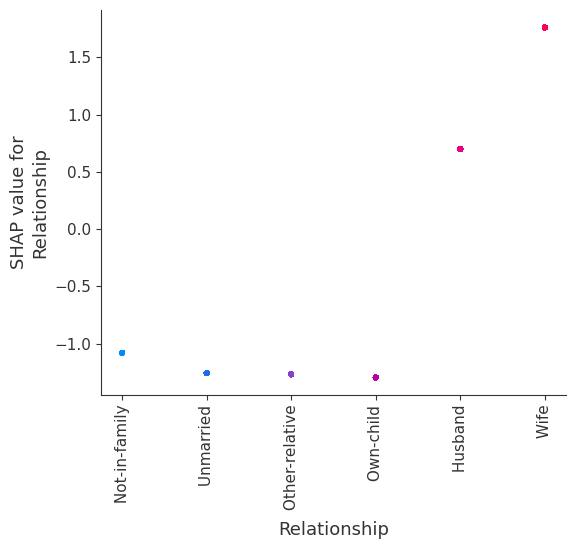

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


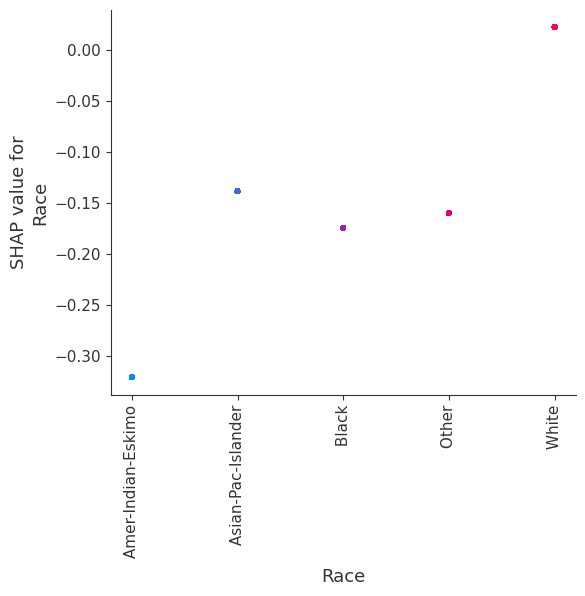

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


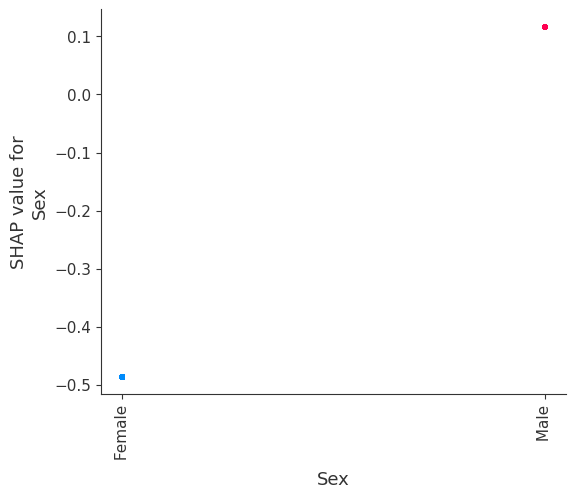

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


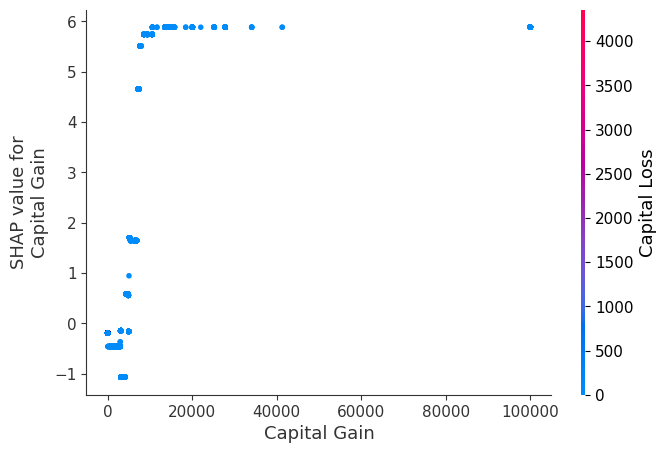

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


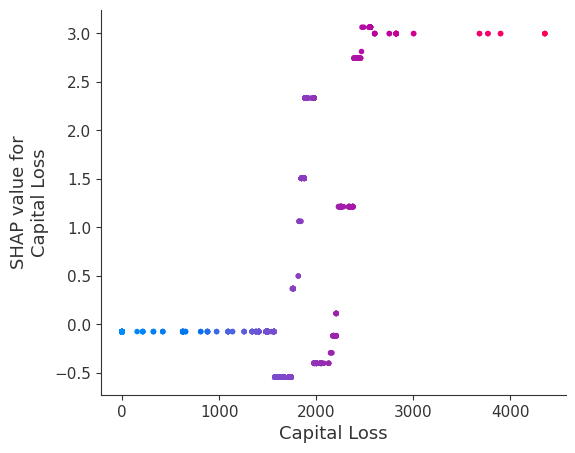

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


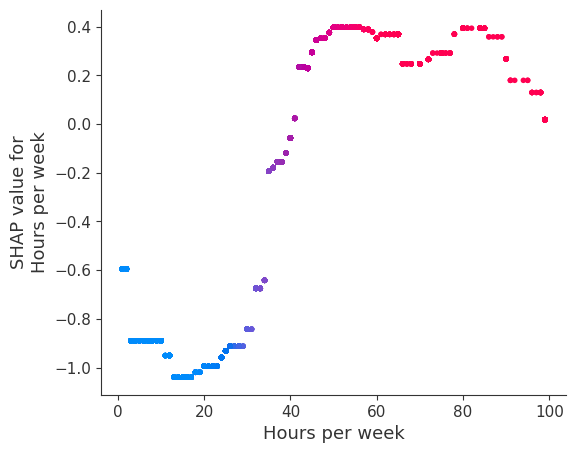

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


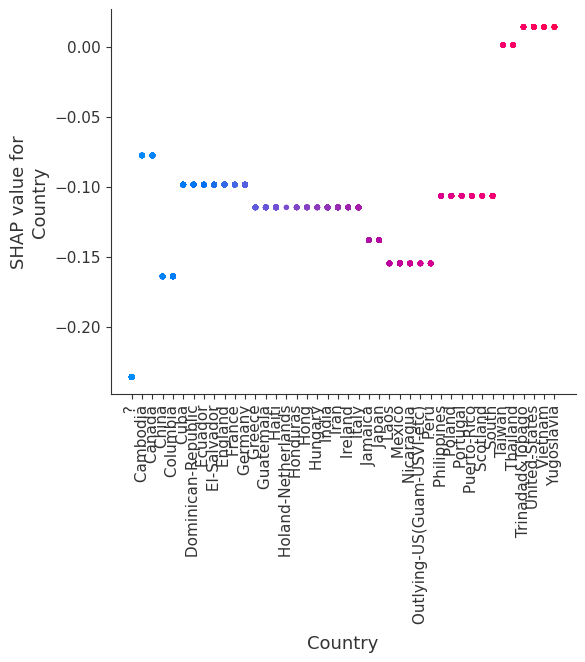

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind, X, display_features=X_display)

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html